# **DSCI 100 Team 11 Project Proposal: [more informative part of title]**

## Introduction

An Electrical Direct Current (DC) Machine can be classified as a DC motor or a DC generator, and it is responsible for altering electromechanical energy depending on the type of machine it is. For example, a DC motor will convert DC electrical power to mechanical power, while a DC generator will do the opposite. DC machines are used in trains, mills, and mines. 

By method of k-nearest neighbours (KNN), using a real dataset about students' knowledge status on the subject of Electrical DC Machines, we will answer the question of how the knowledge level on Electrical DC Machines of a user is classified based on two predictors from the dataset: PEG, the exam performance of the user for goal objects (knowledge on Electrical DC Machines), and LPR, the exam performance of the user for related objects (knowledge on subjects related to Electrical DC Machines) with the goal object (knowledge on Electrical DC Machines). We want to predict the knowledge level on Electrical DC Machines of a user given their PEG and LPR. 

This dataset is an Excel spreadsheet that has 403 rows and 6 columns, and it has been split into a training dataset with 258 rows, and a testing dataset with 145 rows which are each on separate sheets. Of it’s 6 columns, 5 columns are the predictors STG (the degree of study time for goal object materials), SCG (the degree of repetition number of user for goal object materials), STR (the degree of study time of user for related objects with goal object), LPR (the exam performance of user for related objects with goal object), and PEG (the exam performance of user for goal objects), and the last one is the response variable, UNS (the knowledge level on Electrical DC Machines of the user), which includes 5 different categories: Very Low, Low, Middle, and High. The data was collected from a PhD thesis and has no missing values. 

## Preliminary exploratory data analysis

First, we will read our dataset into R. Taking a look into the .xls file, there are 3 sheets: the first has metadata, the second training data, and the third testing data. Since the training and testing sets have already been determined and are on different sheets, we'll load them to separate dataframes. In addition, both training and testing datasets have attribute information to the side of the datasets, so we'll have to specify our ranges to keep the attribute information from being read as a variable.

In [19]:
library(tidyverse)
library(readxl)

ukn_train <- read_excel("Data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", # training data
                                   sheet = 2, 
                                   range = "A1:F259")
ukn_test <- read_excel("Data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", # test data
                                  sheet = 3,
                                  range = "A1:F146")
head(ukn_train)
head(ukn_test)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Inspecting the data, we can see that our data is already mostly tidied: each of the cell values occurs only once, each vector represents one variable, and each row one observation. All numerical vectors are `<dbl>`.

Since our categorical class is currently `<chr>`, we will convert it into `<fct>` type.

Let's also standardize the naming scheme across testing and training sets: `UNS` in the training set has a category called "very_low", while in the testing set is named "Very Low". We want these to be the same, so we'll rename "very_low" in the training data to "Very Low" to match with the naming conventions of the other categories (capitalized words, no underscores).

Finally, we should also standardize (centre and scale) our data.

In [23]:
ukn_train_scaled <- ukn_train |>
    mutate(UNS = as_factor(UNS)) |>   # convert <chr> to <fct>
    mutate(UNS = fct_recode(UNS, "Very Low" = "very_low")) |>   # standardizing UNS category names
    mutate(STG = scale(STG),   # standardizing numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))

ukn_test_scaled <- ukn_test |>
    mutate(UNS = as_factor(UNS)) |>   # convert <chr> to <fct>
    mutate(STG = scale(STG),   # standardizing numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))

head(ukn_train_scaled)
head(ukn_test_scaled)

STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.765089,-1.6780077,-1.9029207,-1.7440515,-1.7967053,Very Low
-1.384627,-1.3005822,-1.4963171,-0.7767309,1.7297900,High
-1.479743,-1.3949386,-1.6996189,-0.7364259,-0.5036570,Low
-1.289512,-1.2062258,-1.2930153,0.8757751,-0.6212069,Middle
-1.384627,-1.3005822,-1.5776378,2.2058409,-0.8563066,Low
-1.337070,-0.9703348,-0.2765062,-1.3410013,0.7893912,Middle


STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.5142778,-1.1525157,0.2452099,-0.6155307,-1.4020025,Very Low
-1.2784849,-1.3772532,0.4470002,0.6235230,-1.0884978,Low
-1.1370092,-0.7929358,0.7698645,0.6235230,1.3847057,High
-0.5711065,-0.7030408,0.9716548,0.8786222,1.3847057,High
-0.4767893,-0.6131458,1.8595318,-0.4697597,1.5588750,High
-0.8540579,-0.9727257,1.0523709,0.2590954,-0.5311562,Low


deets on summarizing training data

In [25]:
# code summarizing training data -- decide what summary statistics etc to use

We know that `UNS`, the knowledge level of the user, is going to be our categorical class. From here we have to decide what variables to use as our predictors. Creating a few simple scatterplots can help us visualize the relationships of numerical variables with each other (two at a time) and with the categorical class. We aren't going to use every nuerical variable as a predictor, so we will look for those with the strongest relationships with the classifier.

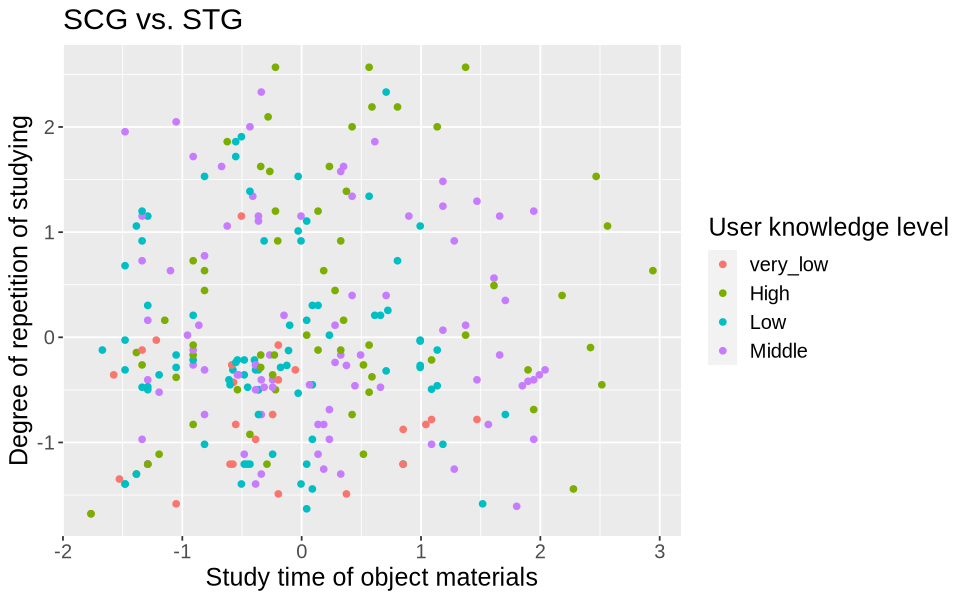

In [24]:
# code visualizing training data

options(repr.plot.height = 5, repr.plot.width = 8)

ggplot(uk_train_scaled,
       aes(x = STG,
           y = SCG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Study time of object materials',
         y = 'Degree of repetition of studying',
         colour = 'User knowledge level',
         title = 'SCG vs. STG') +
    theme(text = element_text(size = 15))

# figure out how many and what graphs to plot (25 seems excessive)

more text talking about plot results and decision on what predictors to use

## Methods

#### **Explain how you will conduct either your data analysis and which variables/columns you will use.**

We aim to classify the knowledge level of users (UNS) as "High", "Middle", "Low", or "Very Low" based on their exam performance for goal objects (PEG) and exam performance for related objects with goal object (LPR). For this classification analysis, we will employ the K-nearest neighbors classification algorithm with our 2 predictor variables being PEG and LPR, to predict and classify the categorical variable, UNS.

#### **Describe at least one way that you will visualize the results.**

One way we will visualize our results is through a **scatter plot** with the PEG on the y-axis as it is our response variable and LPR on the x-axis as it is our predictor variable. We will add aesthetic mapping by distincitvely colouring each data point based on their knowledge level ("High", "Middle", "Low", or "Very Low").

## Expected outcomes and significance

What do you expect to find?

We expect the UNS (Knowledge level of the user about Electrical DC Machines) to be positively related to their LPR and PEG (Exam performance on objects related to ELectrical DC Machines and exam performance on Electrical DC Machines). The better the performance on the exam, the better will be their overall knowledge of Electrical DC Machines.
Moreover, we expect to see a positive relationship between LPR and PEG.

What impact could such findings have?

Analyzing these findings can help to create effective study curricula for electrical DC machines for computer science students. We can use these data to alter study times and information about related subject areas to improve user knowledge of the subject.

What future questions could this lead to?

Some future questions that this can lead to:
1. To what extent does study time of related subject areas affect the exam performance of our target study area?
2. Does studying related subject areas improve user knowledge of our target study area?
3. 